# Predicting behaviour of C. elegans from the its brain's wiring diagram using network principles

<img src="assets/yan2018_worm.jpg" alt="disease network" style="float:right" width="750" />


Regarding the brain as a network is another great starting point to apply graph theory. This idea of modelling the brain using network science is far from new, but having the computational tools to do anything interesting about it is. This notebook deals with one of such application on the much studied nematode C. *elegans*. The adult worm has only 959 cells. It has 302 neurons, 282 of which are play a role in controlling the body movement (the remaining 20 control the pharynx). A number of studies have mapped this connection diagram (*connectome*), and a complete (although error-prone) map exists freely available from https://www.wormatlas.org.

In [a Nature study](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5710776/) by Yan et al., the C. *elegans* connectome was analysed using control theory to identify neurons which are especially crucial for motor control. The finding was later experimentally validated by laser ablation of the neurons, making it a brilliant example of how clever use of algorithms can be used to make predictions of complex real world networks like the brain. Here we will attempt to reproduce parts of that study. 

Relevant literature:
- https://www.barabasilab.com/publications/caenorhabditis-elegans-and-the-network-control-framework-faqs
- https://www.barabasilab.com/publications/synthetic-ablations-in-the-c-elegans-nervous-system
- http://barabasi.com/f/919.pdf
- https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1001066
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1995545/
- https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1001066
- https://www.kaggle.com/rubmanoid/c-elegans-connectome #data

Validation data from the experiment (video): https://figshare.com/s/72716a92be1ab0f1e1d4

Useful information: https://www.wormatlas.org/neuronalwiring.html#Neuronconnections

Credit goes to (https://github.com/EmmaTowlson/c-elegans-control) for the code to solve the max flow problem. 

### Structure of the notebook
The first part of this notebook deals with basic exploration, cleaning and processing of the data and constructing the graph. We reproduce a figure from the paper (more or less) before we deep dive into the science of control theory with simple examples. Finally we apply the algorithms to the connectome of C. elegans and do virtual ablation studies to determine crucial nodes.

As usual, we start by importing necessary libraries.

In [1]:
import time
import numpy as np
import pandas as pd
from pathlib import Path
import networkx as nx
import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Next we locate and import the connectome data, downloaded from wormatlas.org.

In [2]:
data_dir = Path.cwd() / 'data'
print(data_dir.exists())

data_fn = data_dir / 'NeuronConnect_wormatlas.xls'
print(data_fn.exists())

True
True


In [3]:
# read edge list
data = pd.read_excel(data_fn)

In [4]:
data.head()

,Neuron 1,Neuron 2,Type,Nbr
0,ADAR,ADAL,EJ,1
1,ADFL,ADAL,EJ,1
2,ASHL,ADAL,EJ,1
3,AVDR,ADAL,EJ,2
4,PVQL,ADAL,EJ,1


In [5]:
data.loc[:, 'Type'].unique()

array(['EJ', 'Sp', 'R', 'Rp', 'S', 'NMJ'], dtype=object)

The data is stored as an edge list: each row holds two neurons which are connected. **Neuron 1** is the pre-synaptic neuron and **Neuron 2** is the post-synaptic neuron. **Type** is the synapse category, and **Nbr** is the number of synapses from Neuron1 to Neuron2.

#### Exercise 1. How many neurons are there?

In [6]:
data.describe(include='all').T.unique

Neuron 1    281
Neuron 2    281
Type          6
Nbr         NaN
Name: unique, dtype: object

In [7]:
# %load solutions/ex4_1.py

data.loc[:,'Neuron 1'].unique().shape # one way

data.describe(include='all').T.unique # another way
# should be 281

Neuron 1    281
Neuron 2    281
Type          6
Nbr         NaN
Name: unique, dtype: object

Next we do not care about the type of connection, and will remove the column.

#### Ex 2: a) remove the *Type* and Number column. 

In [8]:
# %load solutions/ex4_2a.py
data.drop(['Type','Nbr'], axis=1, inplace=True)
#comment: the "inplace=True" ensures that the data is dropped in place, without needing to write something 
#along the lines of data = data.drop(...) 

In [9]:
data.head(2)

,Neuron 1,Neuron 2
0,ADAR,ADAL
1,ADFL,ADAL


#### b) rename the columns to "source" and "target"

In [10]:
# %load solutions/ex4_2b.py
#Rename to source and target 
data.columns = ['source', 'target']

In [11]:
data.head(2)

,source,target
0,ADAR,ADAL
1,ADFL,ADAL


## Load muscle cells
The current data only holds information about the neurons. We also need to know the connections to the muscles, as these are the cells that control motion.

In [12]:
muscles_fn = data_dir / 'Neuron_to_muscles_wormatlas.xls'
print(muscles_fn.exists())

True


#### Ex 3a). Read the excel file into a pandas dataframe called 'muscles'.

In [13]:
# %load solutions/ex4_3a.py
muscles = pd.read_excel(muscles_fn)

#### b) We don't care about the column "Landmark Position" or weight. Discard them.

In [14]:
# %load solutions/ex4_3b.py
muscles.drop(columns=['Landmark Position', 'Weight'], inplace=True)

In [15]:
muscles.head(3)

,Neuron,Landmark
0,IL1R,Sensory
1,IL2L,Sensory
2,IL2R,Sensory


In [16]:
muscles.shape

(650, 2)

Here we see the motor neurons and the muscle or other cell type they are connected to (landmark).

In [17]:
muscles.Landmark.unique()

array(['Sensory', 'SensoryNB', 'MDL05', 'MDR05', 'MDL08', 'MDR08',
       'MDL07', 'MDR07', 'MDL10', 'MDR10', 'MDL09', 'MDR09', 'MDL12',
       'MDR12', 'MDL11', 'MDR11', 'MDL14', 'MDR14', 'MDL13', 'MDR13',
       'MDL16', 'MDR16', 'MDL15', 'MDR15', 'MDL18', 'MDR18', 'MDL20',
       'MDR20', 'MDL17', 'MDR17', 'MDL19', 'MDR19', 'MDL22', 'MDR22',
       'MDL21', 'MDR21', 'MVL12', 'MVL11', 'MVL14', 'MVR14', 'MVL10',
       'MVR10', 'MVL03', 'MVR04', 'MANAL', 'MVULVA', 'MDL02', 'MDL01',
       'MDL04', 'MDR02', 'MDR01', 'MDL03', 'MVL01', 'MDR03', 'MVR01',
       'MVR03', 'MVL02', 'MVR02', 'MVL22', 'MVR21', 'MVL09', 'MVL13',
       'MVR05', 'MVL05', 'MVL07', 'MVR06', 'MVR08', 'MVL06', 'MVL08',
       'MDR04', 'MVR07', 'MVL04', 'MDL06', 'MDR06', 'MVR09', 'MVR12',
       'MVR11', 'MVR13', 'MVL16', 'MVR16', 'MVL15', 'MVR15', 'MVL18',
       'MVR18', 'MVL17', 'MVR17', 'MVL19', 'MVR19', 'MVL20', 'MVR20',
       'MVL21', 'MVR22', 'MVL23', 'MVR23', 'MVR24', 'MDL24', 'MDL23',
       'MDR24', 'MDR23

As seen above, the data contains information about other connections too, like input from sensory cells, and muscle cells of no interest. We wish to only keep body wall muscles (those involved in controlling locomotion).

In [18]:
## only keep body wall muscles - the ones with name prefixes MDR/L or MVR/L.
# pandas supports regex:
bodywall = muscles.loc[:,"Landmark"].str.match(pat = "^M[DV][LR][0-9]") 

#comment: this matching algorithm is known as a regular expression. This one lets you match for a string
#beginning with and M, followed by a D or V, followed by a L or R. In other words it will match anything 
#starting with "MDL", "MDR", "MVL" or "MVR"

In [19]:
# number of body wall muscles
print('Body wall muscles:')
print(muscles[bodywall].loc[:,"Landmark"].unique())
muscles[bodywall].loc[:,"Landmark"].unique().shape

# should be 95

Body wall muscles:
['MDL05' 'MDR05' 'MDL08' 'MDR08' 'MDL07' 'MDR07' 'MDL10' 'MDR10' 'MDL09'
 'MDR09' 'MDL12' 'MDR12' 'MDL11' 'MDR11' 'MDL14' 'MDR14' 'MDL13' 'MDR13'
 'MDL16' 'MDR16' 'MDL15' 'MDR15' 'MDL18' 'MDR18' 'MDL20' 'MDR20' 'MDL17'
 'MDR17' 'MDL19' 'MDR19' 'MDL22' 'MDR22' 'MDL21' 'MDR21' 'MVL12' 'MVL11'
 'MVL14' 'MVR14' 'MVL10' 'MVR10' 'MVL03' 'MVR04' 'MDL02' 'MDL01' 'MDL04'
 'MDR02' 'MDR01' 'MDL03' 'MVL01' 'MDR03' 'MVR01' 'MVR03' 'MVL02' 'MVR02'
 'MVL22' 'MVR21' 'MVL09' 'MVL13' 'MVR05' 'MVL05' 'MVL07' 'MVR06' 'MVR08'
 'MVL06' 'MVL08' 'MDR04' 'MVR07' 'MVL04' 'MDL06' 'MDR06' 'MVR09' 'MVR12'
 'MVR11' 'MVR13' 'MVL16' 'MVR16' 'MVL15' 'MVR15' 'MVL18' 'MVR18' 'MVL17'
 'MVR17' 'MVL19' 'MVR19' 'MVL20' 'MVR20' 'MVL21' 'MVR22' 'MVL23' 'MVR23'
 'MVR24' 'MDL24' 'MDL23' 'MDR24' 'MDR23']


(95,)

#### c) Remove the rows in `muscles` which are not body wall muscles.

In [20]:
# %load solutions/ex4_3c.py
muscles = muscles[bodywall] #boolean indexing

In [21]:
muscles.head()

,Neuron,Landmark
86,ADEL,MDL05
87,AS01,MDL05
88,AS01,MDR05
89,AS01,MDL08
90,AS01,MDR08


We chain the two dataframes (neurons and muscles) together to obtain the full wiring diagram.

In [22]:
muscles.rename(columns = dict(zip(muscles.columns, data.columns)), inplace=True)
data = data.append(muscles, ignore_index=True)
data.head()

,source,target
0,ADAR,ADAL
1,ADFL,ADAL
2,ASHL,ADAL
3,AVDR,ADAL
4,PVQL,ADAL


In [23]:
data.tail()

,source,target
6964,DA09,MDR23
6965,AS11,MDL24
6966,AS11,MDL23
6967,AS11,MDR24
6968,AS11,MDR23


In [24]:
muscles.describe().T.unique

source    118
target     95
Name: unique, dtype: object

#### Exercise 4. Obtain the set of muscle cells and set of motor neurons. Call them `motor_neurons` and `muscle_cells`. 

In [25]:
# %load solutions/ex4_4.py
motor_neurons = muscles.loc[:,'source'].unique()
muscle_cells = muscles.loc[:,'target'].unique()

# Create the graph
We can now construct the graph using networkx.

#### exercise 5. Construct the graph `G`. Ensure it is a directional graph.

In [26]:
# %load solutions/ex4_5a.py
G = nx.from_pandas_edgelist(data, create_using=nx.DiGraph)

In [27]:
print(G.number_of_nodes())

378


Currently, the network is (strangely) disconnected - some subnetworks are unreachable from eachother - possibly because of incomplete data. We can remove the nodes which are not connected to the main network.

In [28]:
[cc for cc in nx.connected_components(nx.Graph(G))] # have to convert to undirected graph first

[{'ADAL',
  'ADAR',
  'ADEL',
  'ADER',
  'ADFL',
  'ADFR',
  'ADLL',
  'ADLR',
  'AFDL',
  'AFDR',
  'AIAL',
  'AIAR',
  'AIBL',
  'AIBR',
  'AIML',
  'AIMR',
  'AINL',
  'AINR',
  'AIYL',
  'AIYR',
  'AIZL',
  'AIZR',
  'ALA',
  'ALML',
  'ALMR',
  'ALNL',
  'ALNR',
  'AQR',
  'AS01',
  'AS02',
  'AS03',
  'AS04',
  'AS05',
  'AS06',
  'AS07',
  'AS08',
  'AS09',
  'AS10',
  'AS11',
  'ASEL',
  'ASER',
  'ASGL',
  'ASGR',
  'ASHL',
  'ASHR',
  'ASIL',
  'ASIR',
  'ASJL',
  'ASJR',
  'ASKL',
  'ASKR',
  'AUAL',
  'AUAR',
  'AVAL',
  'AVAR',
  'AVBL',
  'AVBR',
  'AVDL',
  'AVDR',
  'AVEL',
  'AVER',
  'AVFL',
  'AVFR',
  'AVG',
  'AVHL',
  'AVHR',
  'AVJL',
  'AVJR',
  'AVKL',
  'AVKR',
  'AVL',
  'AVM',
  'AWAL',
  'AWAR',
  'AWBL',
  'AWBR',
  'AWCL',
  'AWCR',
  'BAGL',
  'BAGR',
  'BDUL',
  'BDUR',
  'CEPDL',
  'CEPDR',
  'CEPVL',
  'CEPVR',
  'DA01',
  'DA02',
  'DA03',
  'DA04',
  'DA05',
  'DA06',
  'DA07',
  'DA08',
  'DA09',
  'DB01',
  'DB02',
  'DB03',
  'DB04',
  'DB05',
 

Scroll all the way down and see a component disconnected to the rest of the graph, consisting of the 2 nodes `avfl` and `avfr`. This is a matter of incomplete data, but for the sake of the math, we should delete these two nodes from the graph:

#### b) remove those nodes and print the number of nodes before and after.

In [118]:
# %load solutions/ex4_5b.py
print(G.number_of_nodes())
G.remove_nodes_from(['avfl', 'avfr'], )
print(G.number_of_nodes())

376
376


## Identifying hubs
The nodes sorted by degree indicate the more influential nodes (high degree) versus less influential.

In [30]:
deg = sorted(G.degree(), key = lambda x: x[1], reverse=True)
print('Top degrees:')
deg[:10]

Top degrees:


[('AVAR', 186),
 ('AVAL', 184),
 ('AVBL', 150),
 ('AVBR', 148),
 ('NMJ', 115),
 ('AVER', 112),
 ('AVDR', 110),
 ('AVEL', 110),
 ('PVCL', 108),
 ('PVCR', 106)]

#### Exercise 6. Make a numpy array `node_list` of the node degrees in G. Do not sort it (it is important that it appears in the same order as G.nodes, because we will use it for plotting later).

In [31]:
# %load solutions/ex4_6.py
node_degrees = np.array([e for v,e in list(G.degree())])

In [32]:
#nx.draw_networkx_nodes(G, pos=nx.kamada_kawai_layout(G), node_color=colors.values())#,
#                       #node_size=node_degrees*10)

### Assign properties to each node based on the category (sensory, muscle...)

In [33]:
landmark = pd.read_excel('data/NeuronFixedPoints.xls')
landmark.head()

,Neuron,Landmark,Landmark Position,Weight
0,IL1R,Sensory,0.0,1.0
1,IL2L,Sensory,0.0,1.0
2,IL2R,Sensory,0.0,1.0
3,IL1L,Sensory,0.0,1.0
4,IL2VL,Sensory,0.0,1.0


These data has a different category each muscle cell (those that starts with 'M'). In other words, the neurons that innervate them are motor neurons. We will replace them with just 'Motor'.

In [34]:
lmks=landmark.iloc[:,[0,1]]
print(lmks.Landmark.unique())

# hacky
lmks.replace('^M[DV][LR]', np.nan, regex=True, inplace=True)
lmks.fillna('Motor', inplace=True)
lmks.Landmark.unique()

['Sensory' 'SensoryNB' 'MDL05' 'MDR05' 'MDL08' 'MDR08' 'MDL07' 'MDR07'
 'MDL10' 'MDR10' 'MDL09' 'MDR09' 'MDL12' 'MDR12' 'MDL11' 'MDR11' 'MDL14'
 'MDR14' 'MDL13' 'MDR13' 'MDL16' 'MDR16' 'MDL15' 'MDR15' 'MDL18' 'MDR18'
 'MDL20' 'MDR20' 'MDL17' 'MDR17' 'MDL19' 'MDR19' 'MDL22' 'MDR22' 'MDL21'
 'MDR21' 'MVL12' 'MVL11' 'MVL14' 'MVR14' 'MVL10' 'MVR10' 'MVL03' 'MVR04'
 'MANAL' 'MVULVA' 'MDL02' 'MDL01' 'MDL04' 'MDR02' 'MDR01' 'MDL03' 'MVL01'
 'MDR03' 'MVR01' 'MVR03' 'MVL02' 'MVR02' 'MVL22' 'MVR21' 'MVL09' 'MVL13'
 'MVR05' 'MVL05' 'MVL07' 'MVR06' 'MVR08' 'MVL06' 'MVL08' 'MDR04' 'MVR07'
 'MVL04' 'MDL06' 'MDR06' 'MVR09' 'MVR12' 'MVR11' 'MVR13' 'MVL16' 'MVR16'
 'MVL15' 'MVR15' 'MVL18' 'MVR18' 'MVL17' 'MVR17' 'MVL19' 'MVR19' 'MVL20'
 'MVR20' 'MVL21' 'MVR22' 'MVL23' 'MVR23' 'MVR24' 'MDL24' 'MDL23' 'MDR24'
 'MDR23']


array(['Sensory', 'SensoryNB', 'Motor', 'MANAL', 'MVULVA'], dtype=object)

In [35]:
lmks.head()

,Neuron,Landmark
0,IL1R,Sensory
1,IL2L,Sensory
2,IL2R,Sensory
3,IL1L,Sensory
4,IL2VL,Sensory


In [37]:
mapping = dict(lmks.values)

# set node attributes
dummy = {k:v for k,v in zip(G.nodes, np.repeat('Unknown', G.number_of_nodes()))}
nx.set_node_attributes(G, dummy, 'Type')
nx.set_node_attributes(G, mapping, 'Type')

# color the muscle cells themselves
mapping = {k:'Muscle' for k in G.nodes if k.startswith('M')}
nx.set_node_attributes(G, mapping, 'Type')

# define color scheme for figure based on neuron type
colors = nx.get_node_attributes(G, 'Type') 
# set some colors
cattocol = {'Unknown':'orange', 
            'Sensory':'dodgerblue', 
            'SensoryNB':'green', 
            'Motor':'yellow', 
            'Muscle':'fuchsia', 
            'MANAL':'motor',
            'MVULVA':'motor'}

for k,v in colors.items():
    colors[k] = cattocol[v]

In [38]:
# now you see each node has been given an attribute "Type"
G.nodes['AVM']

{'Type': 'SensoryNB'}

In [39]:
nx.get_node_attributes(G,'Type')

{'ADAR': 'Unknown',
 'ADAL': 'Unknown',
 'ADFL': 'Sensory',
 'ASHL': 'Sensory',
 'AVDR': 'Unknown',
 'PVQL': 'Unknown',
 'ADEL': 'Motor',
 'AIAL': 'Unknown',
 'AIBL': 'Unknown',
 'AIBR': 'Unknown',
 'AVAR': 'Unknown',
 'AVBL': 'Unknown',
 'AVBR': 'Unknown',
 'AVDL': 'Unknown',
 'AVEL': 'Unknown',
 'AVJR': 'Unknown',
 'AWAL': 'Sensory',
 'FLPR': 'Sensory',
 'PVPL': 'Unknown',
 'PVR': 'Sensory',
 'RICL': 'Unknown',
 'RICR': 'Unknown',
 'RIML': 'Motor',
 'RIPL': 'Unknown',
 'RMGL': 'Motor',
 'SMDVR': 'Motor',
 'ADFR': 'Sensory',
 'ASHR': 'Sensory',
 'PVQR': 'Unknown',
 'ADER': 'Sensory',
 'AIAR': 'Unknown',
 'AVAL': 'Unknown',
 'AVJL': 'Unknown',
 'RIMR': 'Motor',
 'RIPR': 'Unknown',
 'RIVR': 'Motor',
 'RMGR': 'Motor',
 'SMDVL': 'Motor',
 'URBR': 'Sensory',
 'AINL': 'Unknown',
 'AVKR': 'Motor',
 'ALA': 'Unknown',
 'AVL': 'Motor',
 'BDUL': 'Unknown',
 'CEPDL': 'Sensory',
 'FLPL': 'Sensory',
 'IL1L': 'Motor',
 'IL2L': 'Sensory',
 'OLLL': 'Sensory',
 'RIAL': 'Unknown',
 'RIFL': 'Unknown',
 '

#### Exercise 7. Plot the network, set the node size to be proportional to the node degrees, and color to from color.values(). 
Hint: due to slow plotting it is adviced to experiment with some dummy data. You can make a dummy dataset using `nx.erdos_renyi_graph`. Furthermore, networkx has separate functions for drawing edges and nodes and labels, you should use these (`nx.draw_networkx_nodes` etc.).

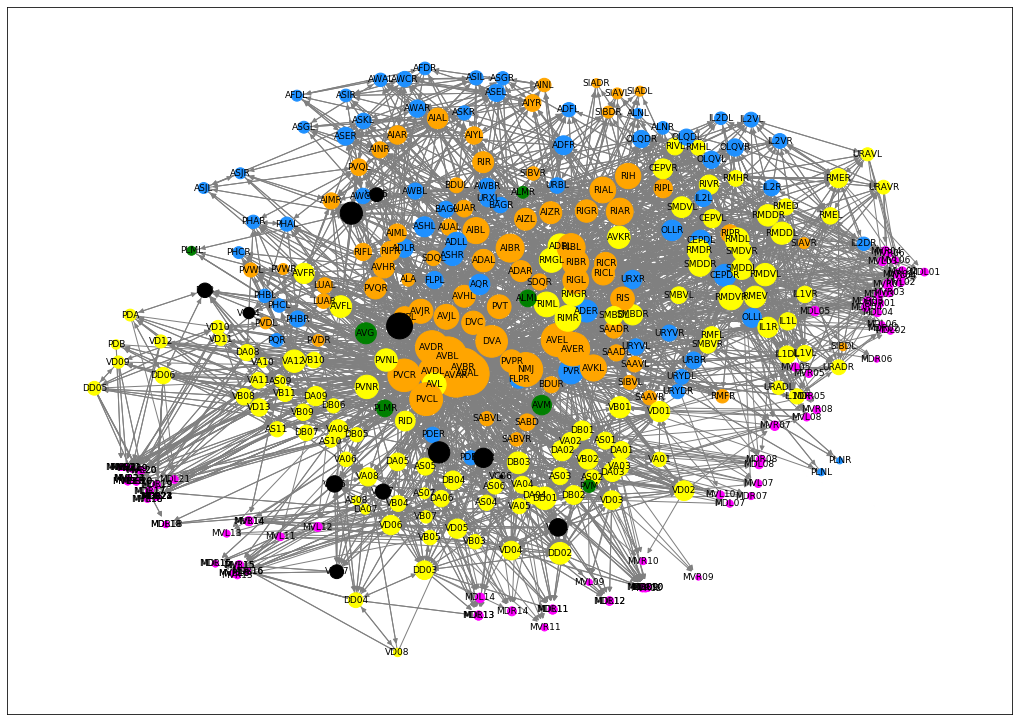

In [344]:
# %load solutions/ex4_7.py

figsize = (18,13)
plt.figure(figsize=figsize)

pos = nx.kamada_kawai_layout(G)


nx.draw_networkx_nodes(G, pos, node_color=colors.values(),
                       node_size=node_degrees*10)

nx.draw_networkx_edges(G, pos, edge_color='gray')

nx.draw_networkx_labels(G, pos, font_size=9)

plt.show()

In [40]:
deg[:10]

[('AVAR', 186),
 ('AVAL', 184),
 ('AVBL', 150),
 ('AVBR', 148),
 ('NMJ', 115),
 ('AVER', 112),
 ('AVDR', 110),
 ('AVEL', 110),
 ('PVCL', 108),
 ('PVCR', 106)]

So already, simply by computing the node degree, our attention is directed to the most influential nodes. How do we know these are more important? Previous experimental evidence has shown that the four top nodes, AVAR, AVAL, AVBR, AVBL, are especially important for locomotive function. This is not surprising, considering how many connections that are lost by removing one of them.

The neurons AVDR, PVCR, PVCL, AVDL which are ranked at 6th, 8th, 9th and 11th in the node degree hierarchy have also been expermentally validated as being crucial (by damaging any of these neurons, the worm would have locomotive defects). 

Before we proceed, ee can also experiment with other topological metrics.

In [41]:
btw = nx.betweenness_centrality(G)
srtd = sorted(btw.items(), key = lambda item: item[1], reverse=True)
print('Top degrees:')
srtd[:10]

Top degrees:


[('AVAL', 0.07966106563092054),
 ('AVAR', 0.0784940278436756),
 ('AVBR', 0.051881294910837886),
 ('AVBL', 0.048344071965715725),
 ('DVA', 0.02929173235726403),
 ('AVER', 0.029046486369105225),
 ('AVEL', 0.02665558309753209),
 ('PVCR', 0.02160957579681925),
 ('RIBL', 0.021181247556025275),
 ('PVCL', 0.021027269430255065)]

Thus we know that simple, straight forward network analysis can take us surprisingly far. However, we shouldn't stop here. First of all, there are many cases of high-degree nodes which *don't* exert any significant power over motion patterns. Secondly, there exists a range of low-degree which *do* play an important role. Identified in Yan et al., were the neurons DD04, DD05, DD06 and PDB.

In [42]:
# How would you identify these seemingly "unimportant" neurons?
# print their degree
for nrn in ['PDB', 'DD04', 'DD05', 'DD06']:
    d = nx.degree(G, nrn)
    print(nrn, d)

PDB 9
DD04 22
DD05 19
DD06 27


# Digression: Network topology of C. elegans

Neuronal signal transmission is expensive. It requires more energy 
to send a signal from A to B through multiple neurons than through 
a single synapse (axonal transmission is less energy demanding). With that assumption in mind we expect evolution to have optimized the wiring costs in the brains of animals, like C elegans.
in other words: path length should be as small as possible. Lets test it!

(Watts and Strogatz, 1998)

To address this question we need to use a topological metric that encapsulates this property of having a minimal number of synapses between any 2 neurons.  

**Characteristic path length :** the average shortest path between a node and all the other nodes in the network.

In [43]:
from networkx.convert_matrix import to_numpy_matrix

In [44]:
matrix = to_numpy_matrix(G)

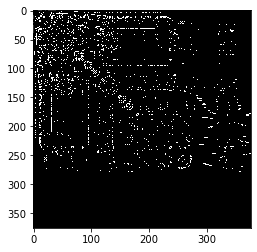

In [45]:
plt.imshow(matrix, cmap='gray')

In [46]:
import bct

In [47]:
bct.number_of_components(matrix+matrix.T)

1

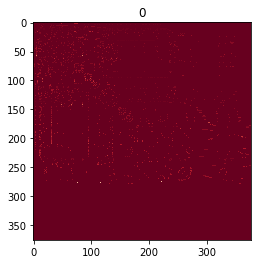

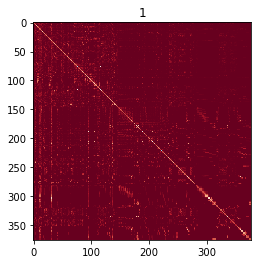

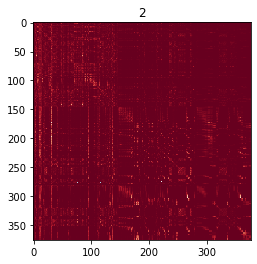

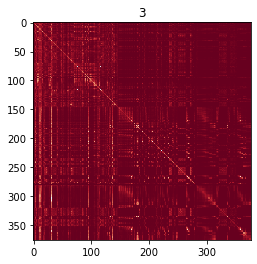

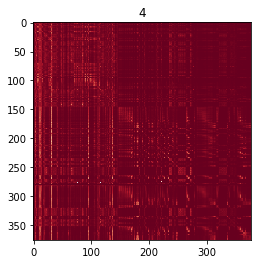

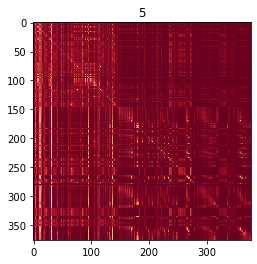

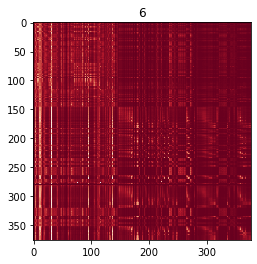

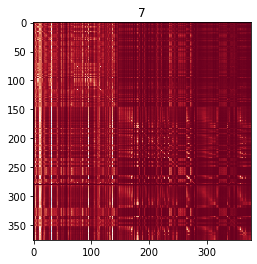

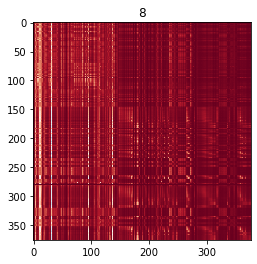

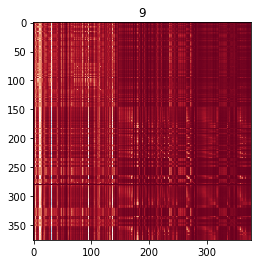

In [48]:
#digression
from itertools import repeat
M = matrix.copy()

#normalize to make a markov transition matrix
def norm_markov(M):
    rowsums = M.sum(1)
    M = M/rowsums
    M = np.nan_to_num(M, copy=False)
    return M

M = norm_markov(M)

for i,m in enumerate(repeat(M, 10)):
    if i%1==0: plt.imshow(M, cmap='RdBu');plt.title(i); plt.show()
    M=norm_markov(M.T@m)



In [49]:
GG = nx.from_numpy_array(M>0, create_using=nx.DiGraph)

In [50]:
nx.number_attracting_components(GG)

2

(array([31., 66., 18., 12., 26., 32., 32., 34., 18., 17., 14., 12., 16.,
        12.,  5.,  6.,  2.,  5.,  3.,  1.,  2.,  0.,  0.,  1.,  0.,  0.,
         1.,  0.,  2.,  2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([  1. ,   4.7,   8.4,  12.1,  15.8,  19.5,  23.2,  26.9,  30.6,
         34.3,  38. ,  41.7,  45.4,  49.1,  52.8,  56.5,  60.2,  63.9,
         67.6,  71.3,  75. ,  78.7,  82.4,  86.1,  89.8,  93.5,  97.2,
        100.9, 104.6, 108.3, 112. , 115.7, 119.4, 123.1, 126.8, 130.5,
        134.2, 137.9, 141.6, 145.3, 149. , 152.7, 156.4, 160.1, 163.8,
        167.5, 171.2, 174.9, 178.6, 182.3, 186. ]),
 <a list of 50 Patch objects>)

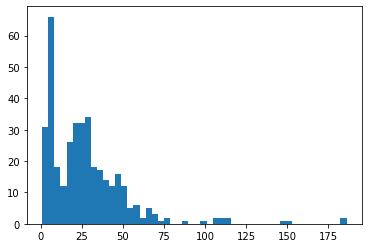

In [52]:
# degree distribution
plt.hist([d for _,d in deg], bins=50)

In [53]:
L = nx.average_shortest_path_length(G)
C = nx.algorithms.cluster.average_clustering(G)
print(L, C)

1.9149078014184397 0.2890001555033106


The average number of "jumps" from one node to another is just below 2. This is surprisingly small, considering the network is around 300 neurons!

Let's compare it to a random graph of the same parameters (n,m): random graphs are known to have a very low hop count. (Random graphs are covered in another notebook).

nodes:  376
edges:  5244
376 5244
nodes:  376
edges:  5244
376 5244


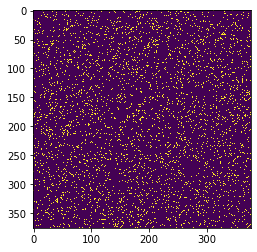

In [233]:
def get_nm(G):
    n=G.number_of_nodes()
    m=G.number_of_edges()
    print("nodes: ", n)
    print("edges: ", m)
    return n,m

n,m = get_nm(G)

print(n, m)
R = nx.gnm_random_graph(n,m)
#R = nx.barabasi_albert_graph(n,7)

n_rand, m_rand = get_nm(R)
print(n_rand, m_rand)

plt.imshow(to_numpy_matrix(R))

In [56]:
L_random = nx.average_shortest_path_length(R)
C_random = nx.algorithms.cluster.average_clustering(R)
print("Random: ", L_random, C_random)
print("Real: ", L, C)

2.0432624113475177 0.0725175340675177
1.9149078014184397 0.2890001555033106


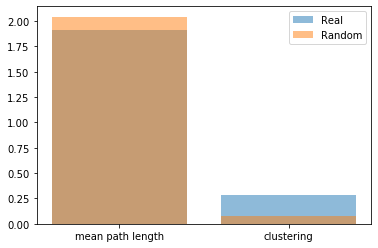

In [70]:
plt.bar([1,2], [L, C], alpha=.5)
plt.bar([1,2], [L_random, C_random], alpha=.5)
plt.xticks(ticks=[1,2], labels=['mean path length','clustering'])
plt.legend(['Real','Random'])

**Conclusion**: The connectome has an average path length almost as low as a random network (minimal). This is what we had expected, testifying to a near-optimal solution of reducing wiring cost. But why then, might you ask, wouldn't it be better for evolution to have gone for a random topology, to get the path length even a little lower?

The answer lies in the clustering coefficient, which is much higher in the C. elegans connectome. What is the meaning of the clustering coefficient? Does it have an evolutionary reason? Sporns (2004) argues that clustering facilitates segregation and thus specialization in subnetworks of the brain. Consider the primary visual cortex: it makes sense for it to have a higher intra-connectivity than inter-connectivity to any other arbitrary region, so it can focus on performing the task of early visual processing. 

This combination of a low L and high C is the characteristic trait of a small-world network. The small-world network can thus be seen as a trade-off between high communication efficiency (L) and high specialization (C).

# Control theory

<img src="assets/controllable.png" width="200" style="float:left"/>

To understand how Yan et al. was able to identify crucial neurons, we must introduce the field of control theory: based on the wiring diagram and some input signals, how can we achieve optimal control of the desired nodes (muscles)? Is it possible to have independent control over the muscle cells? Each muscle cell is innervated by motor neuron - the interface from neuron and mucle. Just from the definitions it is obvious that obliterating a motor neuron has a crucial impact on motor function. 


A basic result says that if we wish to control *k* output units independently, and have control over *m* nodes directly connected, then *m*>*k*. In other words, if we have 50 motor neurons connected to 60 muscle cells, we cannot have complete independent control over each muscle. Note that this is only true when the *m* nodes in questions are *directly* connected to the output.

Introducing some mathematical formalism, we can determine whether a system *is* controllable, using three inputs: the wiring diagram, the nodes we wish to control, and the nodes receiving our signals.

First, M is the number of control targets (muscles). N is the number of neurons. The connection diagram of the neurons and muscles is an N+M x N+M matrix, **A**. **B** is a (N+M)xS matrix signifying which nodes receive external control signals (e.g. sensory signals). **C** is a matrix, where each row signifies which units we attempt to control (i.e. the muscles).  

Kalman's criterion is a theoretical prerequisite for a system to be controllable: 
$$ rank [CB, CAB, CA^2B, ..., CA^{N+M+1}B] = M$$

A problem with computing this is that there exist an incomprehensible amount of configurations for the edge weights, and we would need to test all of them. Instead the researchers used *structural controlability*, which is only dependent on the connectome *structure*, without regarding its exact synapse weights or the input signals.

In [71]:
# don't worry about understanding the code
from numpy.linalg import matrix_power, matrix_rank

def is_kalman(A,B,C, random_state=1):
    M = C.shape[0]
    return kalman(controllability_matrix(A,B,C), M, random_state=random_state)

def kalman(kal, M, random_state=1):
    """
    Checks whether kalman condition is satisfied for a system. 
    Non-zero weights are randomly set to avoid a Lebesque measure of zero.
    """
    kal_rnd = np.random.rand(*kal.shape)#*kal
    rnk = matrix_rank(kal*kal_rnd)
    print(f"Rank = {rnk} \t M = {M}")
    return(rnk == M)

def controllability_matrix(A,B,C):
    """
    Returns
    -------
    the matrix [CB, CAB, CA^2B....CA^(M+N-1)B]
    """
    M = C.shape[0]
    N = A.shape[0] - M
    ll = [_controllability_matrix(A,B,C,k) for k in range(M+N)]
    if ll[0].ndim == 1: return np.vstack(ll)#.T
    return np.concatenate(ll, axis=1)

def _controllability_matrix(A,B,C,k):
    """
    Helper function, computes matrix product C@A^k@B
    """
    AA = matrix_power(A,k)
    return C@AA@B
   #if k==0: return C@B
   #return _controllability_matrix(A, B, C@B, k-1)


#### Simple example

we have N=2 neurons and M=2 muscles. We name the cells (neurons and muscles combined) from 1 to 4 (which is assigned as 1, which is 2... is not important). The connectivity diagram is represented as a matrix A, below. B is the matrix of which cells receive external input (i.e. sensory input). C is the one-hot encoded matrix over nodes we wish to control (just 1 for muscle cells and 0 for neurons).

In [72]:
# TODO: colorize B and C
def show_sys(A,B,C, plot=True):   
    for l,e in zip(["A","B","C"],(A,B,C)): print(l,':\n', e, end='\n\n')
        
    if plot == True:
        H = nx.from_numpy_array(A.T, create_using=nx.DiGraph)
        pos = nx.kamada_kawai_layout(H)
        n = A.shape[0]
        labels={k:v for k,v in zip(range(n), np.arange(n)+1)}
        nx.draw(H, pos=pos, with_labels=True, labels=labels)

The matrix entries are set to 1 just to signify a connection, but the actual weight is not necessarily 1 (in fact that is highly unlikely. 

In [73]:
#from sklearn.preprocessing import OneHotEncoder
#enc = OneHotEncoder()
#
#trans = enc.fit_transform(C)
#trans.toarray()
#B = np.array([[0]]) # to receive sensory signal
#B = enc.fit_transform(B).toarray()
#C = np.array([[1,2]]) # to be controlled
#C = enc.fit_transform(C).toarray()

In [74]:
A = np.array([[0,0,0],
              [1,0,0],
              [1,0,0]]) # connectome diagram

B = np.array([[1,0,0]]).T  # the nodes to receive signal
C = np.array([[0,1,0],[0,0,1]]) # the nodes to control


A :
 [[0 0 0]
 [1 0 0]
 [1 0 0]]

B :
 [[1]
 [0]
 [0]]

C :
 [[0 1 0]
 [0 0 1]]



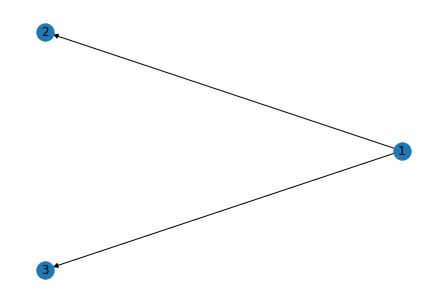

In [75]:
show_sys(A,B,C)

In [76]:
is_kalman(A,B,C)

Rank = 1 	 M = 2


False

A :
 [[0 0 0]
 [1 0 0]
 [1 0 0]]

B :
 [[1 0]
 [0 1]
 [0 0]]

C :
 [[0 1 0]
 [0 0 1]]



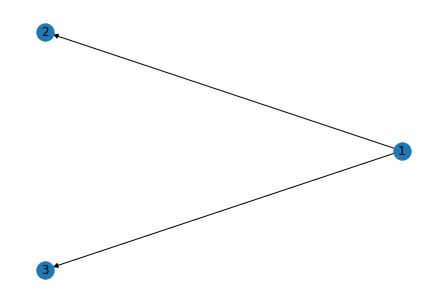

In [77]:
# lets give signal to both first and second
B = np.array([[1,0,0],[0,1,0]]).T
show_sys(A,B,C)

In [78]:
# now it is controllable
is_kalman(A,B,C)

Rank = 2 	 M = 2


True

In [79]:
# a larger example
A = np.array([[0,0,0,0],
              [1,0,0,0],
              [1,0,0,0],
              [0,0,1,0]])

# only neuron #1 receives an input signal
B = np.array([[1,0,0,0]]).T

# we wish to control those indexed 1 and 3
C = np.array([[0,1,0,0],
             [0,0,0,1]])

M = C.shape[0]
N = A.shape[0] - M
print(M, N)

2 2


A :
 [[0 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 1 0]]

B :
 [[1]
 [0]
 [0]
 [0]]

C :
 [[0 1 0 0]
 [0 0 0 1]]



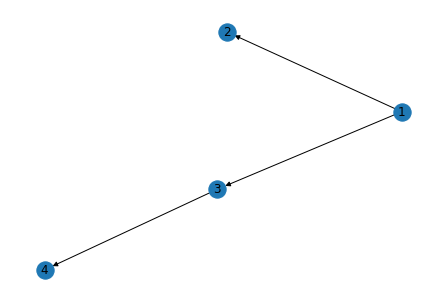

In [80]:
show_sys(A,B,C)

In [81]:
controllability_matrix(A,B,C)

array([[0, 1, 0, 0],
       [0, 0, 1, 0]])

In [82]:
is_kalman(A,B,C)

Rank = 2 	 M = 2


True

In this case we change the desired control units from 2 and 4 to 2 and 3.

A :
 [[0 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 1 0]]

B :
 [[1]
 [0]
 [0]
 [0]]

C :
 [[0 1 0 0]
 [0 0 1 0]]

Rank = 1 	 M = 2


False

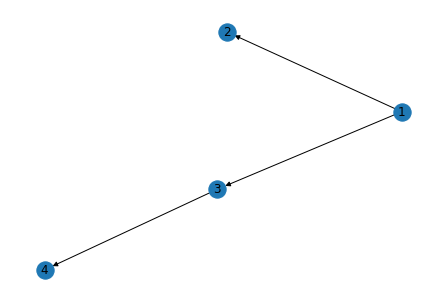

In [83]:
# another case
C = np.array([[0,1,0,0],
              [0,0,1,0]])
show_sys(A,B,C)
is_kalman(A,B,C)

In [84]:
controllability_matrix(A,B,C)

array([[0, 1, 0, 0],
       [0, 1, 0, 0]])

In [85]:
# example from Liu et al (2011) https://www.nature.com/articles/nature10011.pdf
A = np.array([[0,0,0,0],
              [1,0,0,0],
              [1,0,0,1],
              [1,0,0,0]])

B = np.array([[1,0,0,0],
             [0,1,0,0]]).T

C = np.eye(*A.shape)

M = C.shape[0]; N=A.shape[0]-M
print(M, N)

4 0


A :
 [[0 0 0 0]
 [1 0 0 0]
 [1 0 0 1]
 [1 0 0 0]]

B :
 [[1 0]
 [0 1]
 [0 0]
 [0 0]]

C :
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]



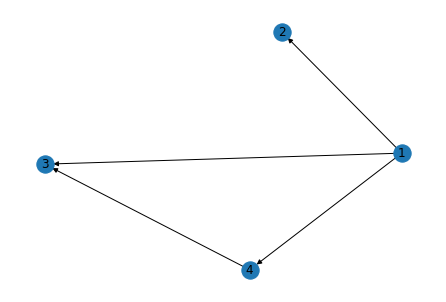

In [86]:
show_sys(A,B,C)

In [87]:
is_kalman(A,B,C)

Rank = 4 	 M = 4


True

# Maximum matching and linking graphs
*This first part about max matching is under development and can be skipped*

The problem with this approach is that we only get a single answer (yes or no) if the particular configuration of B and C make it controllable. We have no idea way to find these nodes, or even just the number of them.

In fact, not all of the 95 muscles are independently controllable - only 89 are. And this number probably allows many different combinations. So to determine this number of controllable nodes, we introduce concept of maximum matching and linking graphs.

In [88]:
nx.is_bipartite(G)

False

In [89]:
G.is_directed()

True

In [90]:
nx.max_weight_matching(nx.Graph(G))

{('ADAR', 'AVBR'),
 ('ADER', 'SAAVR'),
 ('ADFR', 'AIZR'),
 ('ADLR', 'OLLR'),
 ('AFDL', 'ASER'),
 ('AFDR', 'AWAR'),
 ('AIML', 'ASGL'),
 ('AIMR', 'ASJR'),
 ('AINR', 'BAGR'),
 ('AIYR', 'AIYL'),
 ('AIZL', 'ASIL'),
 ('ALA', 'RID'),
 ('AS01', 'MDR05'),
 ('AS04', 'MDR11'),
 ('AS06', 'MDL13'),
 ('AS07', 'MDR16'),
 ('AS09', 'MDR17'),
 ('AS11', 'MDR23'),
 ('ASGR', 'AINL'),
 ('ASJL', 'ASKL'),
 ('ASKR', 'AIAR'),
 ('AUAL', 'IL2DL'),
 ('AVAL', 'FLPR'),
 ('AVBL', 'ADAL'),
 ('AVEL', 'IL1R'),
 ('AVER', 'RMDVR'),
 ('AVFL', 'MVL11'),
 ('AVFR', 'PVNL'),
 ('AVJR', 'URXL'),
 ('AVKL', 'PVPL'),
 ('AVKR', 'MVL10'),
 ('AVL', 'RIS'),
 ('AWAL', 'ASEL'),
 ('AWBR', 'AWBL'),
 ('AWCL', 'AIAL'),
 ('AWCR', 'ASIR'),
 ('BAGL', 'AQR'),
 ('BDUL', 'ALML'),
 ('BDUR', 'URADR'),
 ('CEPDL', 'OLQDL'),
 ('CEPVL', 'URAVL'),
 ('CEPVR', 'MVR04'),
 ('DA02', 'MDR07'),
 ('DA05', 'MDL14'),
 ('DA06', 'MDR12'),
 ('DB01', 'VB03'),
 ('DB03', 'MDR13'),
 ('DB05', 'MDL18'),
 ('DD05', 'MDL20'),
 ('DVA', 'AUAR'),
 ('DVB', 'PHCL'),
 ('HSNL', 'ASH

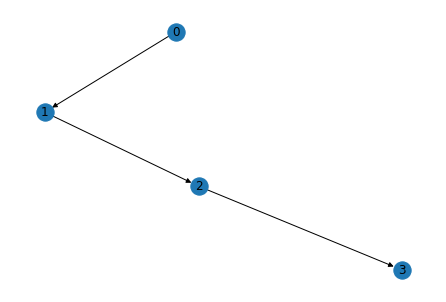

In [92]:
H = nx.path_graph(4, create_using=nx.DiGraph)
nx.draw(H, with_labels=True)

In [93]:
nx.max_weight_matching(H)

{(0, 1), (2, 3)}

In [94]:
star = np.array([[0,0,0,0],
                 [1,0,0,0],
                 [1,0,0,0,],
                 [1,0,0,0]]).T

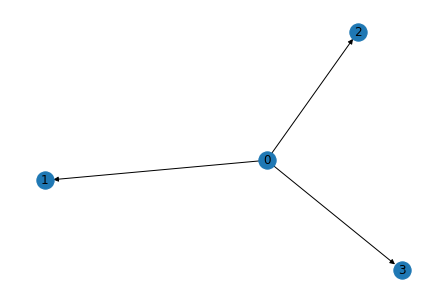

In [95]:
H = nx.from_numpy_array(star, create_using=nx.DiGraph)
nx.draw(H, with_labels=True)

In [96]:
nx.maximal_matching(H)

{(0, 1)}

In [97]:
nx.max_weight_matching(nx.Graph(H))

{(0, 3)}

In [98]:
star = np.array([[0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]]).T

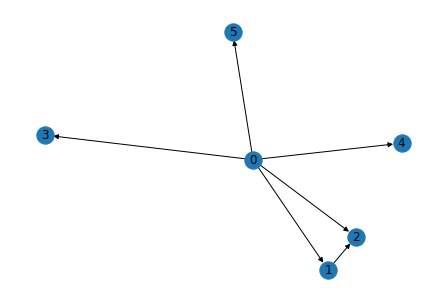

In [99]:
H = nx.from_numpy_array(star, create_using=nx.DiGraph)
nx.draw(H, with_labels=True)

In [100]:
nx.maximal_matching(H.to_undirected())

{(0, 1)}

In [101]:
nx.max_weight_matching(H.to_undirected())

{(0, 5), (1, 2)}

In [102]:
# general:
max_matching = nx.max_weight_matching(H.to_undirected())
N_D = len(max_matching)

H.number_of_nodes() - N_D # number of controllable nodes

4

Problem: the above method is not helpful for directed networks.

In [127]:
G.number_of_nodes()

374

In [103]:
max_matching = nx.max_weight_matching(G.to_undirected())

In [104]:
G.number_of_nodes() - len(max_matching)

191

The above only works for *undirected* graphs. Generalize it. 

In [123]:
# make bipartite representation of digraph 
# https://www.hindawi.com/journals/mpe/2016/4702387/
F = nx.Graph()
Vp = list(G.nodes) # V+
Vm = Vp.copy()     # V-
Vp = list(map(lambda n: n+'+', Vp))
Vm = list(map(lambda n: n+'-', Vm))

In [124]:
F.add_nodes_from(Vp)
F.add_nodes_from(Vm)

In [125]:
for u, v in G.edges:
    F.add_edge(u+'+', v+'-')

In [126]:
F.number_of_edges()

5244

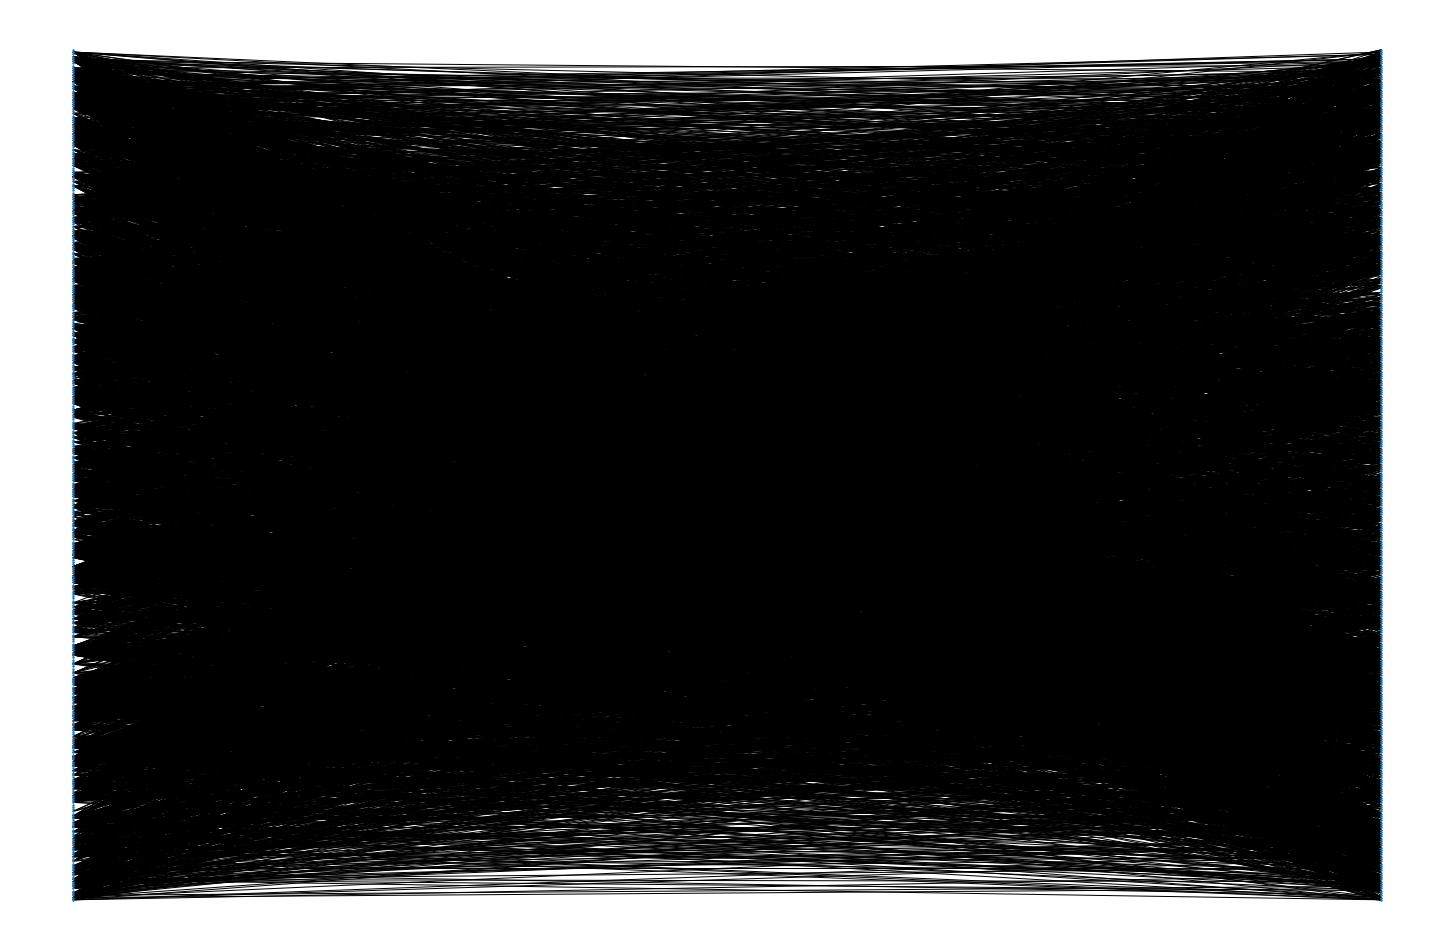

In [127]:
plt.figure(figsize=(20,13))
nx.draw(F, pos=nx.bipartite_layout(F, Vp), node_size=2)

In [128]:
# now F is a bipartite representation of G

In [129]:
to_remove = list(nx.connected_components(F))[1:]
to_remove = [st.pop() for st in to_remove] # get rid of nested sets

In [130]:
len(to_remove)

97

In [131]:
F.remove_nodes_from(to_remove)

In [132]:
max_matching = nx.algorithms.bipartite.matching.hopcroft_karp_matching(F)

In [133]:
MM = len(max_matching)
MM

560

In [134]:
F.number_of_nodes()

655

In [135]:
# minimum number of nodes needed to control G fully
N_D = max(F.number_of_nodes() - len(max_matching), 1)
N_D 

95

In [136]:
# the driver nodes are the unmatched nodes

#Definition 4. For a digraph, matching is a subset of edges with no common starting-nodes
#or no common ending-nodes. That is to say, no two edges in share a common starting-node 
#or a common ending-node. A node is matched if it is an ending-node of a matching edge. 
#Otherwise, it is unmatched.


matched_nodes = {v[:-1] for _,v in max_matching.items()}

In [137]:
matched_nodes.difference??

In [138]:
unmatched_nodes = set(G.nodes()).difference(matched_nodes)

In [140]:
list(unmatched_nodes)[:10]

['MDR08',
 'MVL04',
 'MDL10',
 'MVR09',
 'MVR13',
 'MVL18',
 'MVR17',
 'MVL08',
 'MDR05',
 'MDR10']

# How to determine the number of controllable nodes: linking graphs

<img src="assets/linking_graph.png" width=750 />


The mathematics of network flow: 
https://sites.cs.ucsb.edu/~suri/cs231/Flows.pdf


In [141]:
### credit to Towlson et al for the code below
### Available (and slightly modified) from:
### https://github.com/EmmaTowlson/c-elegans-control for the code to follow

In [142]:
# linking size (derived from linking graph) sets upper bound to number of controllable nodes

def linking_graph(G, sensors, sinks, depth):
    """
    Construct a bipartite linking graph from nx.DiGraph G
    """
    H = nx.DiGraph() 
    for edge in G.edges():
        u,v = edge
        c = u + 'a1'
        d = v + 'a1'
        
        if not H.has_node(c):
                for i in range(1,depth+1):
                        H.add_edge(u+'a'+str(i),u+'b'+str(i),capacity=1)
        if not H.has_node(d):
                for i in range(1,depth+1):
                        H.add_edge(v+'a'+str(i),v+'b'+str(i),capacity=1)
        if not H.has_edge(u+'b'+str(2),v+'a'+str(1)):
            for i in range(2,depth+1):
                    H.add_edge(u+'b'+str(i),v+'a'+str(i-1),capacity=1)
    
    ## add 'Source' nodes into the linking graph
    for s in sensors:
        for i in range(1,depth+1):
            H.add_edge('SOURCE', s+'a'+str(i), capacity=100)
            
    ## add 'Sink' nodes into the linking graph
    for s in sinks:
        H.add_edge(s+'b1', 'SINK', capacity=100)
    
    return H


In [143]:
# not working, ignore
def lg(G, sensors, sinks, depth=120):
    H = nx.DiGraph()
    for u,v in G.edges():   
        for t in range(depth):
            H.add_edge(u+str(t), v+str(t+1), capacity=1)
    for s in sensors:
        for t in range(depth):
            H.add_edge('SOURCE', s+str(t), capacity=100)
            
    for s in sinks: 
        H.add_edge(s+str(depth), 'SINK', capacity=100)
            
    return H

Simple example first (from above figure)

In [144]:
D = nx.DiGraph()
edge_list=[('x1','x2'),('x1','x3'), ('x3','x4')]
D.add_edges_from(edge_list)

In [145]:
F1 = lg(D, sensors=['x1'], sinks=['x2','x4'], depth=4)
F2 = linking_graph(D, sensors=['x1'], sinks=['x2','x4'], depth=4)

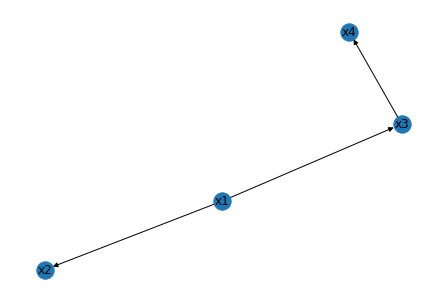

In [146]:
nx.draw(D, with_labels=True)

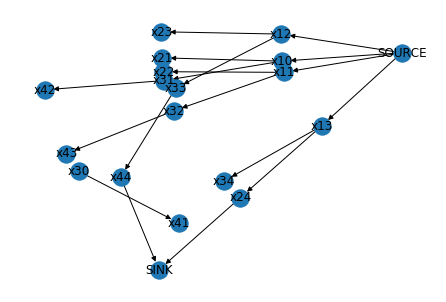

In [147]:
nx.draw(F1,pos=nx.layout.kamada_kawai_layout(F1), with_labels=True)

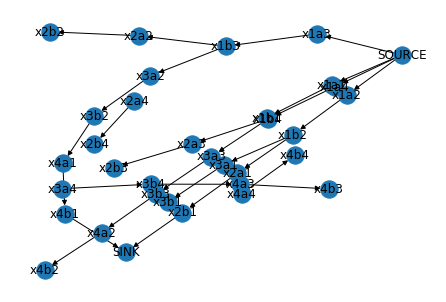

In [148]:
nx.draw(F2,pos=nx.layout.kamada_kawai_layout(F2), with_labels=True)

In [149]:
flow_value, flow_dict = nx.maximum_flow(F1, 'SOURCE', 'SINK')
flow_value

2

In [150]:
flow_dict

{'x10': {'x21': 0, 'x31': 0},
 'x21': {},
 'x11': {'x22': 0, 'x32': 0},
 'x22': {},
 'x12': {'x23': 0, 'x33': 1},
 'x23': {},
 'x13': {'x24': 1, 'x34': 0},
 'x24': {'SINK': 1},
 'x31': {'x42': 0},
 'x32': {'x43': 0},
 'x33': {'x44': 1},
 'x34': {},
 'x30': {'x41': 0},
 'x41': {},
 'x42': {},
 'x43': {},
 'x44': {'SINK': 1},
 'SOURCE': {'x10': 0, 'x11': 0, 'x12': 1, 'x13': 1},
 'SINK': {}}

In [151]:
flow_value, flow_dict = nx.maximum_flow(F2, 'SOURCE', 'SINK')
flow_value

2

In [152]:
flow_dict

{'x1a1': {'x1b1': 0},
 'x1b1': {},
 'x1a2': {'x1b2': 1},
 'x1b2': {'x2a1': 1, 'x3a1': 0},
 'x1a3': {'x1b3': 1},
 'x1b3': {'x2a2': 0, 'x3a2': 1},
 'x1a4': {'x1b4': 0},
 'x1b4': {'x2a3': 0, 'x3a3': 0},
 'x2a1': {'x2b1': 1},
 'x2b1': {'SINK': 1},
 'x2a2': {'x2b2': 0},
 'x2b2': {},
 'x2a3': {'x2b3': 0},
 'x2b3': {},
 'x2a4': {'x2b4': 0},
 'x2b4': {},
 'x3a1': {'x3b1': 0},
 'x3b1': {},
 'x3a2': {'x3b2': 1},
 'x3b2': {'x4a1': 1},
 'x3a3': {'x3b3': 0},
 'x3b3': {'x4a2': 0},
 'x3a4': {'x3b4': 0},
 'x3b4': {'x4a3': 0},
 'x4a1': {'x4b1': 1},
 'x4b1': {'SINK': 1},
 'x4a2': {'x4b2': 0},
 'x4b2': {},
 'x4a3': {'x4b3': 0},
 'x4b3': {},
 'x4a4': {'x4b4': 0},
 'x4b4': {},
 'SOURCE': {'x1a1': 0, 'x1a2': 1, 'x1a3': 1, 'x1a4': 0},
 'SINK': {}}

## Finding the upper bound
There exist no known way to reliably determine the number of nodes controllable in a given network architecture. However, there is one method to determine the upper bound, and one for the lower bound. The above method found the upper bound, and we will do this now to the connectome.

In [153]:
print(G.number_of_nodes()) #374
print(G.number_of_edges()) #5129

376
5244


In [154]:
sensors = ['AVM','ALML','ALMR'] # anterior gentle touch
H = linking_graph(G, sensors, muscle_cells, 120) # depth 120 was found empirically

In [156]:
# test
#H = lg(G, sensors, muscle_cells, 120)

In [157]:
# The upper bound of muscle controllability for the healthy worm
start = time.time()
flow_value, flow_dict = nx.maximum_flow(H, 'SOURCE', 'SINK')
end = time.time()
print('When no ablation, the Upper Bound is:')
print(flow_value)
print('time == ' + str(end-start))
print('\n')

When no ablation, the Upper Bound is:
89
time == 58.350791215896606




In [371]:
#89/537

No more than 89 of the 95 neurons can be controlled completely independently. Now this is the upper bound, so it can in principle be much lower. We also need to find this lower bound.

# Find lower bound

#### From the article:
*When the nodes in the target set do not receive the external control signals u(t) directly,
the network can be separated into two subnetworks, GO and GM (see the schematic picture
Extended Data Figure 2(e)), where GO contains a subnetwork GS, each node in which
receives the external signals directly, and a subnetwork GD, each node in which directly
connects to the nodes in the target set. The set of nodes in GM, GS and GD are denoted
8
by VM, VS and VD respectively. Firstly, taking into account the high density of real neural
networks, search for a subnetwork in (GO in GD) that can be fully structurally controlled
by the nodes VS; Secondly, add GD's nodes (and their associated links) one-by-one into the
subnetwork found in the first step, until the new subnetwork cannot be fully controlled
by VS. Denote the VD's subset that are in the nal subnetwork GF found in this step as
VD-; Thirdly, search for a maximum matching [S30] from VD- to VM, obtaining a node set
U  VM that are covered by this matching. Note that there may be many congurations
of U but its cardinality z is unique. This is the lower bound.*

In [254]:
import random
import time
import re
from random import shuffle
from networkx.algorithms.flow import shortest_augmenting_path
from networkx.algorithms.flow import preflow_push
from networkx.algorithms.flow import edmonds_karp

#### first subgraph (sensory to inter to motor neurons)

In [159]:
sensors = ['ALML','ALMR','AVM']
depth = 50

G_nomuscle = G.copy()
G_nomuscle.remove_nodes_from(muscle_cells)

# test 1 - those laballed 'Motor' in G
motor_neurons = [k for k,v in nx.get_node_attributes(G,'Type').items() if v=='Motor']
len(motor_neurons) #126

H = linking_graph(G_nomuscle, sensors, motor_neurons, depth)

In [160]:
print(G.number_of_nodes())
G.number_of_edges()

376


5244

In [161]:
flow_value, flow_dict = nx.maximum_flow(H,'SOURCE','SINK')

print(flow_value)

# ensure that flow_value == number of motor neurons

115


In [162]:
print(flow_value)
print(len(motor_neurons))

115
115


So far so good

#### Second subgraph (motor neurons to muscles)

In [378]:
#motor_to_muscle = muscles[bdwl][['Neuron','Landmark']]
#motor_to_muscle.columns = ['source', 'target']
muscles # should be 552 edges if neuron:muscle_connections.txt

,source,target
86,ADEL,MDL05
87,AS01,MDL05
88,AS01,MDR05
89,AS01,MDL08
90,AS01,MDR08
...,...,...
645,DA09,MDR23
646,AS11,MDL24
647,AS11,MDL23
648,AS11,MDR24


In [166]:
muscles.describe().T.unique

source    118
target     95
Name: unique, dtype: object

In [247]:
G_onlymuscle = nx.from_pandas_edgelist(muscles)
get_nm(G_onlymuscle)

nodes:  213
edges:  552


(213, 552)

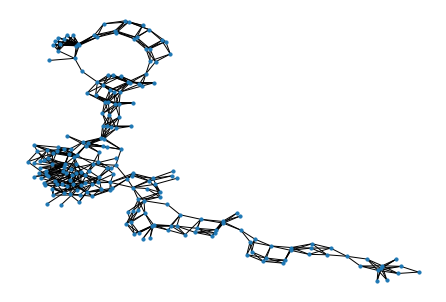

In [202]:
nx.draw(G_onlymuscle, pos=nx.kamada_kawai_layout(G_onlymuscle), node_size=10)

In [203]:
list(motor_neurons).__len__()

115

In [213]:
set.difference??

In [214]:
set(motor_neurons).difference(set(emma))

set()

In [215]:
set(emma).difference(set(motor_neurons))

{'DVB',
 'HSNL',
 'HSNR',
 'RMFR',
 'VA07',
 'VB06',
 'VC01',
 'VC02',
 'VC03',
 'VC04',
 'VC05',
 'VD07'}

In [210]:
len(set(emma))

127

In [211]:
len(set(motor_neurons))

115

In [241]:
muscles.target.unique()

array(['MDL05', 'MDR05', 'MDL08', 'MDR08', 'MDL07', 'MDR07', 'MDL10',
       'MDR10', 'MDL09', 'MDR09', 'MDL12', 'MDR12', 'MDL11', 'MDR11',
       'MDL14', 'MDR14', 'MDL13', 'MDR13', 'MDL16', 'MDR16', 'MDL15',
       'MDR15', 'MDL18', 'MDR18', 'MDL20', 'MDR20', 'MDL17', 'MDR17',
       'MDL19', 'MDR19', 'MDL22', 'MDR22', 'MDL21', 'MDR21', 'MVL12',
       'MVL11', 'MVL14', 'MVR14', 'MVL10', 'MVR10', 'MVL03', 'MVR04',
       'MDL02', 'MDL01', 'MDL04', 'MDR02', 'MDR01', 'MDL03', 'MVL01',
       'MDR03', 'MVR01', 'MVR03', 'MVL02', 'MVR02', 'MVL22', 'MVR21',
       'MVL09', 'MVL13', 'MVR05', 'MVL05', 'MVL07', 'MVR06', 'MVR08',
       'MVL06', 'MVL08', 'MDR04', 'MVR07', 'MVL04', 'MDL06', 'MDR06',
       'MVR09', 'MVR12', 'MVR11', 'MVR13', 'MVL16', 'MVR16', 'MVL15',
       'MVR15', 'MVL18', 'MVR18', 'MVL17', 'MVR17', 'MVL19', 'MVR19',
       'MVL20', 'MVR20', 'MVL21', 'MVR22', 'MVL23', 'MVR23', 'MVR24',
       'MDL24', 'MDL23', 'MDR24', 'MDR23'], dtype=object)

In [240]:
muscles.source.unique()

array(['ADEL', 'AS01', 'AS02', 'AS03', 'AS04', 'AS05', 'AS06', 'AS07',
       'AS08', 'AS09', 'AS10', 'AS11', 'AVFL', 'AVFR', 'AVKR', 'AVL',
       'CEPVL', 'CEPVR', 'DA01', 'DA02', 'DA03', 'DA04', 'DA05', 'DA06',
       'DA07', 'DA08', 'DA09', 'DB01', 'DB02', 'DB03', 'DB04', 'DB05',
       'DB06', 'DB07', 'DD01', 'DD02', 'DD03', 'DD04', 'DD05', 'DD06',
       'IL1DL', 'IL1DR', 'IL1L', 'IL1R', 'IL1VL', 'IL1VR', 'PDA', 'PDB',
       'PVNL', 'PVNR', 'RID', 'RIML', 'RIMR', 'RIVL', 'RIVR', 'RMDDL',
       'RMDDR', 'RMDL', 'RMDR', 'RMDVL', 'RMDVR', 'RMED', 'RMEL', 'RMER',
       'RMEV', 'RMFL', 'RMGL', 'RMGR', 'RMHL', 'RMHR', 'SMBDL', 'SMBDR',
       'SMBVL', 'SMBVR', 'SMDDL', 'SMDDR', 'SMDVL', 'SMDVR', 'URADL',
       'URADR', 'URAVL', 'URAVR', 'VA01', 'VA02', 'VA03', 'VA04', 'VA05',
       'VA06', 'VA07', 'VA08', 'VA09', 'VA10', 'VA11', 'VA12', 'VB01',
       'VB02', 'VB03', 'VB04', 'VB05', 'VB06', 'VB07', 'VB08', 'VB09',
       'VB10', 'VB11', 'VD01', 'VD02', 'VD03', 'VD04', 'VD05', 'VD0

In [237]:
get_nm(G_onlymuscle)
len(motor_neurons) + len(muscle_cells)


nodes:  213
edges:  552


210

In [259]:
#sensors=muscles.source.unique()
sensors = emma#motor_neurons
depth=5
H = linking_graph(G_onlymuscle, sensors, muscle_cells, depth)
#H = lg(G_onlymuscle, sensors, muscle_cells, depth)


In [260]:
get_nm(H)

nodes:  2177
edges:  4003


(2177, 4003)

In [269]:
flow_value, flow_dict = nx.maximum_flow(H,'SOURCE','SINK')

In [271]:
flow_value # should also be 89, shows 49...

49

## Experiment: can you make the upper bound decrease from ablating neurons?

#### Exercise. Write a function `ablate_test` that takes G and a node, makes a copy of G, removes that node from the copy, and finds the upper bound of controllable nodes. It should finally print the neuron name and the number.

In [383]:
# %load solutions/ex4_8.py

def ablate_test(G, neuron):
    G_abl = G.copy()
    G_abl.remove_node(neuron)
    H = linking_graph(G_abl, sensors, sinks, depth)
    flow_value,_ = nx.maximum_flow(H,'SOURCE','SINK')
    print(node, flow_value)

In [384]:
######################
# We set the following global variables for the experiments

sensors = ['AVM','ALML','ALMR']
sinks = muscle_cells
depth=120

In [ ]:
ablate_test(G, 'PDB')

As you can see, the number of individually controllable nodes was reduced to 88 just by removing this single node. This will happen in the clear minority of single-neuron ablations. Let's confirm more of the findings from Yan et al 2017:

In [377]:
neurons_to_ablate = ['DD04', 'DD05', 'DD06']

for node in neurons_to_ablate:
    ablate_test(G, node)

DD04 88
DD05 88
DD06 88


In [373]:
# some other non-implicated nodes from the DD class
neurons_to_ablate = ['DD01', 'DD02', 'DD03']

for node in neurons_to_ablate:
    ablate_test(G, node)

DD01 89
DD02 89
DD03 89


In [386]:
# the highest degree nodes
neurons_to_ablate = ['AVAR', 'AVAL']

for node in neurons_to_ablate:
    ablate_test(G, node)

AVAR 88
AVAL 88


As we expected, the highest degree nodes are also crucial for maintaining optimal network control.

In [ ]:
# ignore
# https://github.com/asutera/kaggle-connectomics